First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [1]:
from pathlib import Path
tune_dir = Path("../models/ray").resolve()
tune_dir.exists()

True

In [2]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-1]
latest

PosixPath('/home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray/train_2024-06-30_12-38-58')

In [3]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)


analysis = ExperimentAnalysis(latest)


2024-06-30 15:07:21,606	INFO worker.py:1753 -- Started a local Ray instance.
2024-06-30 15:07:23,520	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_f48b369c: FileNotFoundError('Could not fetch metrics for train_f48b369c: both result.json and progress.csv were not found at /home/azureuser/code/mads-exam-24-FalcovdHoogen/models/ray/train_2024-06-30_12-38-58/train_f48b369c_40_data_dir=ref_ph_5a725494,dropout_rate=0.0066,hidden=24,num_classes=5,num_layers=2,shape=16_12,tune_dir=ref_ph_b1_2024-06-30_15-01-43')


So, we find some info:

In [4]:
analysis.results_df.columns


Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'F1scoremicro',
       'F1scoremacro', 'Precisionmicro', 'Recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/hidden', 'config/num_layers', 'config/tune_dir',
       'config/data_dir', 'config/num_classes', 'config/dropout_rate',
       'config/shape'],
      dtype='object')

Let's focus on the parameters we wanted to tune.

In [5]:
import plotly.express as px

plot = analysis.results_df
select = ["Recallmacro", "iterations", "config/hidden_size", "config/dropout", "config/num_layers"]
p = plot[select].reset_index().dropna()


ModuleNotFoundError: No module named 'plotly'

Let's sort by accuracy

In [ ]:
p.sort_values("Accuracy", inplace=True)

Make a parallel plot

In [ ]:
px.parallel_coordinates(p, color="Accuracy")


<Axes: xlabel='config/hidden_size', ylabel='config/num_layers'>

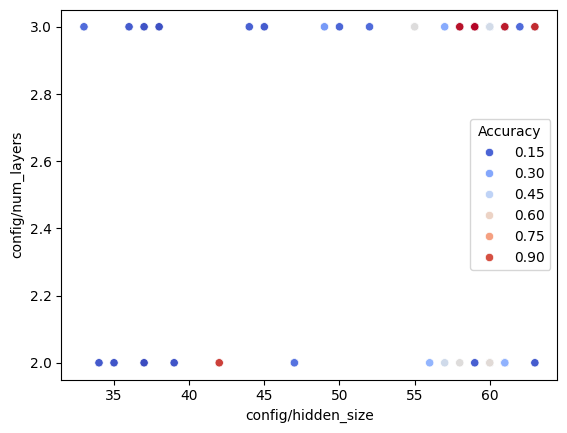

In [ ]:
import seaborn as sns

sns.scatterplot(data=p, x="config/hidden_size", y="config/num_layers", hue="Accuracy", palette="coolwarm")

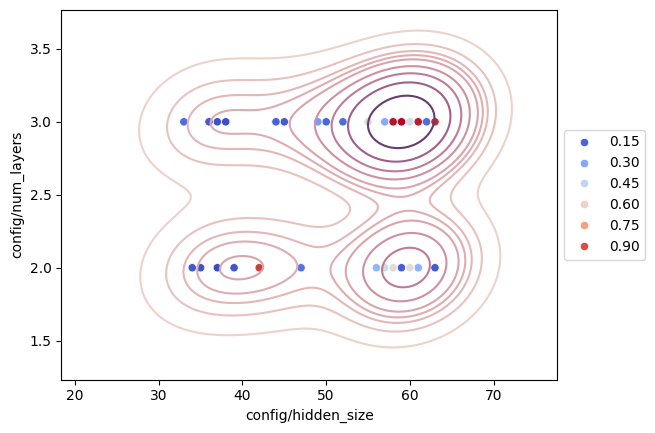

In [ ]:
import matplotlib.pyplot as plt
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data=p, x="config/hidden_size", y="config/num_layers", hue="Accuracy", palette="coolwarm")
sns.kdeplot(data=p, x="config/hidden_size", y="config/num_layers", cmap=cmap)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

In [ ]:
analysis.get_best_trial(metric="test_loss", mode="min")


train_21ae8ba9

The top ten

In [ ]:
p[-10:]


,trial_id,Accuracy,config/hidden_size,config/dropout,config/num_layers
37,5d4f9b53,0.557813,60,0.296922,2
20,6f6cd83e,0.814063,59,0.273672,3
29,636b20f3,0.850000,59,0.176997,3
23,36107137,0.921875,59,0.270489,3
49,fd555ce4,0.925000,42,0.110319,2
9,42915bfb,0.953125,63,0.290803,3
42,bcbeefc7,0.965625,61,0.028128,3
35,2c22f2cd,0.967187,59,0.240035,3
43,96a0a115,0.973437,58,0.024939,3
44,21ae8ba9,0.985938,59,0.051447,3


Or the best config

In [ ]:
analysis.get_best_config(metric="Accuracy", mode="max")


{'input_size': 3,
 'output_size': 20,
 'tune_dir': WindowsPath('C:/Users/Falco/Documents/Python_project/MADS-MachineLearning-course/notebooks/4_tuning_networks/models/ray'),
 'data_dir': WindowsPath('C:/Users/Falco/Documents/Python_project/MADS-MachineLearning-course/notebooks/4_tuning_networks/data/raw/gestures/gestures-dataset'),
 'hidden_size': 59,
 'dropout': 0.051447426737403754,
 'num_layers': 3}